<a href="https://colab.research.google.com/github/aunkon112/sp3/blob/main/Leaf_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import time
st=time.time()

In [8]:
import numpy as np
import pandas as pd
import os
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
PT = "/content/drive/MyDrive/dataset/Datasets/Bacteria"
GL = "/content/drive/MyDrive/dataset/Datasets/Fungi"
MN = "/content/drive/MyDrive/dataset/Datasets/Nematodes"
AB = "/content/drive/MyDrive/dataset/Datasets/Normal"
CD = "/content/drive/MyDrive/dataset/Datasets/Virus"

In [10]:
for i in os.listdir ('/content/drive/MyDrive/dataset/Datasets'):
  print(i,len(os.listdir('/content/drive/MyDrive/dataset/Datasets/'+i)))

Bacteria 50
Fungi 50
Nematodes 49
Virus 50
Normal 40


In [11]:
def get_path_image(folder):
    image_paths = []
    image_fnames = os.listdir(folder)
    for img_id in range(len(image_fnames)):
        img = os.path.join(folder,image_fnames[img_id])
        image_paths.append(img)

    return image_paths

In [12]:
img_data = []

for i in [GL,MN,PT]:
    paths = get_path_image(i)
    img_data.extend(paths)
print(len(img_data))

149


In [13]:
data = {"img_data":img_data,
        "labels":[np.nan for x in range(len(img_data))]}

data = pd.DataFrame(data)

In [14]:
data["labels"][0:50] = 0
data["labels"][51:101] = 1
data["labels"][102:151] = 2
data["labels"][152:202] = 3
data["labels"][203:243] = 4

<ipython-input-14-b3d62876b080>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["labels"][0:50] = 0
<ipython-input-14-b3d62876b080>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["labels"][51:101] = 1
<ipython-input-14-b3d62876b080>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["labels"][102:151] = 2
<ipython-input-14-b3d62876b080>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [15]:
data["labels"] = data["labels"].astype("float64")

#Cropping black edge image

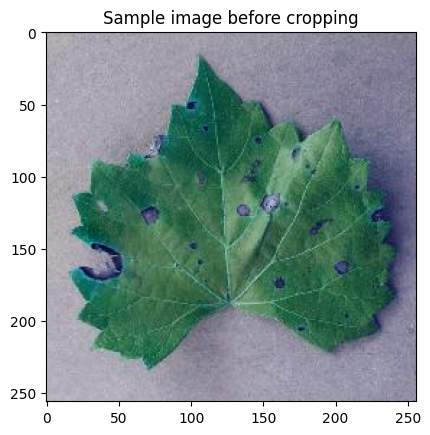

In [16]:
image = cv.imread(data["img_data"][50])
plt.imshow(image)
plt.title("Sample image before cropping")
plt.show()

In [17]:
img_list = []
for i in range(len(img_data)):
    image = cv.imread(data["img_data"][i])
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    thresh = cv.threshold(gray, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)[1]

    result = cv.bitwise_and(image, image, mask=thresh)
    result[thresh==0] = [255,255,255]
    (x, y, z_) = np.where(result > 0)
    mnx = (np.min(x))
    mxx = (np.max(x))
    mny = (np.min(y))
    mxy = (np.max(y))
    crop_img = image[mnx:mxx,mny:mxy,:]
    crop_img_r = cv.resize(crop_img, (400,200))
    img_list.append(crop_img_r)

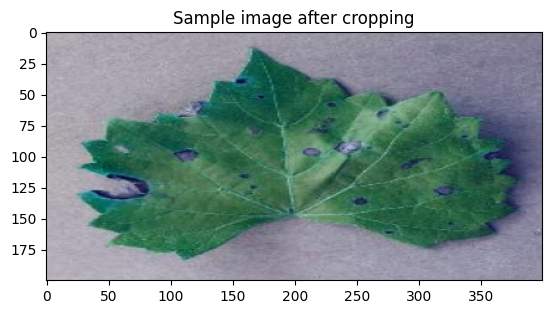

In [18]:
plt.imshow(img_list[50])
plt.title("Sample image after cropping")
plt.show()

In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import applications, models, preprocessing

In [20]:
from tensorflow.keras.applications import ResNet50, ResNet101
from keras.applications.vgg19 import VGG19
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import MobileNetV2
#from transformers import ViTImageProcessor, ViTModel
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.resnet50 import preprocess_input

In [21]:
def feature_extract(model):
    if model == "VGG19": model = VGG19(weights='imagenet',include_top=False, pooling="avg")
    elif model == "ResNet50": model = ResNet50(weights='imagenet',include_top=False,pooling="avg")
    elif model == "ResNet101": model = ResNet101(weights='imagenet',include_top=False,pooling="avg")
    elif model == "InceptionV3": model = InceptionV3(weights='imagenet', include_top=False, pooling="avg")
    elif model == "DenseNet121": model = DenseNet121(weights='imagenet', include_top=False, pooling="avg")
    elif model == "MobileNetV2": model = MobileNetV2(weights='imagenet', include_top=False, pooling="avg")
    else:
      raise ValueError("Unsupported model name: " + model)
    return model

In [22]:
model = feature_extract("VGG19") # or "VGG19", "ResNet101","InceptionV3","DenseNet121","MobileNetV2"

80134624/80134624 [==============================] - 3s 0us/step


In [29]:
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

# Initialize the model
model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

features_list = []
target_size = (300, 200)  # Target size for the images (height, width)

for img in img_list:
    # Ensure the image is a NumPy array and resize it to the target size
    image = Image.fromarray(img)
    image = image.resize(target_size, Image.ANTIALIAS)
    image = np.array(image)

    # Check if the image has the correct number of channels (RGB)
    if image.shape[-1] != 3:
        raise ValueError("Image does not have 3 channels (RGB)")

    # Expand dimensions to add batch size
    image = np.expand_dims(image, axis=0)

    # Preprocess the image according to the model's requirements
    image = preprocess_input(image)

    # For ResNet50, ResNet101, or InceptionV3 models:
    features = model.predict(image).reshape(-1)

    '''# Only for ViT
    # Assuming 'processor' is already defined and loaded
    # Assuming 'model' is a ViT model and is already defined and loaded
    image = preprocess_input(img)
    image = (image - image.min()) / (image.max() - image.min())  # Rescale to the range [0, 1]
    image = (image * 255).astype(np.uint8)
    image = Image.fromarray(image)

    inputs = processor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    features = outputs.last_hidden_state
    features = features.squeeze(0)  # Remove batch dimension
    '''

    features_list.append(features)

# Print or return the feature list as needed
print("Extracted features:", features_list)


94765736/94765736 [==============================] - 4s 0us/step


<ipython-input-29-fab24722efda>:15: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize(target_size, Image.ANTIALIAS)


1/1 [==============================] - 0s 242ms/step
Extracted features: [array([0.8214107 , 0.12059361, 1.2378938 , ..., 0.5754579 , 0.07328618,
       0.59302163], dtype=float32), array([2.4547184 , 0.13101107, 0.38084373, ..., 0.06986193, 0.28299475,
       0.08218557], dtype=float32), array([0.74240917, 0.64434016, 1.4469992 , ..., 0.1441332 , 0.01627436,
       0.30404243], dtype=float32), array([1.9183742 , 0.23308623, 1.3219569 , ..., 0.19283229, 0.26520717,
       0.36113685], dtype=float32), array([0.28144032, 0.6308725 , 2.5769234 , ..., 0.21217428, 0.08105528,
       0.        ], dtype=float32), array([2.2409055 , 0.08364835, 1.3581043 , ..., 0.51396596, 0.04013762,
       0.14309648], dtype=float32), array([3.4936204 , 0.11880544, 0.39083323, ..., 0.0676586 , 0.33170998,
       0.16834335], dtype=float32), array([1.1156024 , 0.2923445 , 1.1294341 , ..., 0.17303745, 0.01566359,
       0.07728308], dtype=float32), array([1.0141793 , 0.2250059 , 1.4184889 , ..., 0.5390282 , 0.

In [30]:
features_df = pd.DataFrame(features_list)

In [31]:
features_df["labels"] = data["labels"]

In [32]:
x = features_df.drop(['labels'], axis = 1)
y = features_df.loc[:,"labels"].values

In [33]:
x

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.821411,0.120594,1.237894,0.000000,0.007460,0.000000,0.021746,0.261424,0.056773,1.057979,...,0.000000,0.082809,0.000000,0.000000,0.026325,1.627385,0.037715,0.575458,0.073286,0.593022
1,2.454718,0.131011,0.380844,0.000000,0.015131,0.007300,0.212984,0.000000,0.056966,0.900388,...,0.000000,0.000000,0.017381,0.000000,0.066303,0.350744,0.006401,0.069862,0.282995,0.082186
2,0.742409,0.644340,1.446999,0.030126,0.158815,0.119832,0.018776,0.054856,0.048293,0.954482,...,0.094339,0.000000,0.020916,0.037736,0.010474,0.280059,0.021111,0.144133,0.016274,0.304042
3,1.918374,0.233086,1.321957,0.008358,0.199919,0.032042,0.164583,0.109623,0.000019,0.591924,...,0.064331,0.001789,0.000000,0.001733,0.021396,0.468746,0.000000,0.192832,0.265207,0.361137
4,0.281440,0.630872,2.576923,0.020501,0.346659,0.055431,0.385584,0.000000,0.018466,0.500969,...,0.043254,0.467066,0.450733,0.056441,0.306614,0.212590,0.047316,0.212174,0.081055,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,1.631732,0.104495,0.625865,0.059348,0.039061,0.000000,0.147931,0.006074,0.022433,1.353884,...,0.027742,0.000000,0.045501,0.000000,0.012568,0.284289,0.107038,0.000000,0.337838,0.887860
145,3.818412,0.051542,0.520536,0.000000,0.020154,0.004449,0.088783,0.018455,0.000000,0.370633,...,0.005550,0.051192,0.133581,0.000000,0.266793,1.612071,0.016669,0.136683,0.406759,0.487076
146,0.698986,0.062938,1.742778,0.043362,0.018510,0.000000,0.039787,0.031037,0.033616,1.281407,...,0.000000,0.013423,0.142724,0.061912,0.118665,1.746397,0.379503,0.631447,0.252115,0.455324
147,4.845640,0.051703,0.146404,0.043724,0.000000,0.025678,0.034621,0.012030,0.001374,0.508968,...,0.042856,0.000000,0.012831,0.000000,0.013846,1.284140,0.233007,0.000000,0.093855,0.860895


In [34]:
print(f"Number of features before feature selection: {x.shape[1]}")

Number of features before feature selection: 2048


In [35]:
y

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., nan,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., nan,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.])

In [36]:
ets=time.time()
et=ets-st
print(f"Execution time:{et}s")

Execution time:1287.2180988788605s


#Data Scaling

In [37]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Example data for demonstration
# Replace this with your actual data
x = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

# Ensure the data is in the correct format (2D array)
if x.ndim == 1:
    x = x.reshape(-1, 1)

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler to the data (calculate min and max values)
scaler.fit(x)

# Transform the data (scale data to the range [0, 1])
x_scaled = scaler.transform(x)

# Print the original and scaled data
print("Original data:\n", x)
print("Scaled data:\n", x_scaled)


Original data:
 [[1 2 3]
 [4 5 6]
 [7 8 9]]
Scaled data:
 [[0.  0.  0. ]
 [0.5 0.5 0.5]
 [1.  1.  1. ]]


In [38]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Example data for demonstration
# Replace this with your actual data
x = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

# Ensure the data is in the correct format (2D array)
if x.ndim == 1:
    x = x.reshape(-1, 1)

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler to the data (calculate min and max values)
scaler.fit(x)

# Transform the data (scale data to the range [0, 1])
x_scaled = scaler.transform(x)

# Convert the scaled data to a pandas DataFrame
x_scaled_df = pd.DataFrame(x_scaled, columns=[f"Feature_{i+1}" for i in range(x_scaled.shape[1])])

# Print the original and scaled data
print("Original data:\n", x)
print("\nScaled data (as DataFrame):\n", x_scaled_df)


Original data:
 [[1 2 3]
 [4 5 6]
 [7 8 9]]

Scaled data (as DataFrame):
    Feature_1  Feature_2  Feature_3
0        0.0        0.0        0.0
1        0.5        0.5        0.5
2        1.0        1.0        1.0


#Feature Selection Methods

ANOVA

In [39]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

def anova_fs():

    selector = SelectKBest(f_classif, k=500) # k is number of features
    selector.fit(x_, y)

    cols = selector.get_support(indices=True)
    anova_x = x_[cols]
    return anova_x

Recursive Feature Elimination (RFE)

In [40]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

def RFE_fs():
    rfe_selector = RFE(estimator=RandomForestClassifier(), n_features_to_select=200, step=0.1)
    rfe_selector.fit(x_, y)

    rfe_support = rfe_selector.support_
    rfe_feature = x_.columns[rfe_support]

    rfe_x = x_[rfe_feature]
    return rfe_x

Random Forest

In [41]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

def rf_fs():
    embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=200, random_state=5), threshold='1.25*median')
    embeded_rf_selector.fit(x_, y)

    embeded_rf_support = embeded_rf_selector.get_support()
    embeded_rf_feature = x_.loc[:,embeded_rf_support].columns.tolist()

    rf_x = x_[embeded_rf_feature]
    return rf_x

Lasso

In [42]:
from sklearn.linear_model import LassoCV

def ls_fs():
    lasso_selector = LassoCV(max_iter=5000)
    lasso_selector.fit(x_, y)

    selected_features = x_.columns[lasso_selector.coef_ != 0]
    ls_X = x_[selected_features]

    return ls_X

PCA

In [100]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel, f_classif, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest

def rf_fs(x_, y):
    rf = RandomForestClassifier()
    rf.fit(x_, y)
    sfm = SelectFromModel(rf, prefit=True)
    X_new = sfm.transform(x_)
    return X_new

def anova_fs(x_, y):
    skb = SelectKBest(score_func=f_classif, k=500)
    X_new = skb.fit_transform(x_, y)
    return X_new

def RFE_fs(x_, y):
    lr = LogisticRegression()
    rfe = RFE(lr, n_features_to_select=500)
    X_new = rfe.fit_transform(x_, y)
    return X_new

def ls_fs(x_, y):
    # Implement your feature selection method
    pass

def pca_fs(x_, n_components=500):
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(x_)
    return X_pca

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

# Load example dataset
data = load_iris()
X, y = data.data, data.target

# Random Forest feature selection
def rf_fs(X, y):
    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(X, y)
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]
    return X[:, indices[:len(importances)]]

# ANOVA feature selection
def anova_fs(X, y, k=10):
    selector = SelectKBest(score_func=f_classif, k=k)
    X_new = selector.fit_transform(X, y)
    return X_new

# Recursive Feature Elimination
def RFE_fs(X, y, n_features_to_select=10):
    model = LogisticRegression()
    rfe = RFE(model, n_features_to_select=n_features_to_select)
    X_rfe = rfe.fit_transform(X, y)
    return X_rfe

# Principal Component Analysis
def pca_fs(X, n_components=10):
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    return X_pca

# Loadings Scores
def ls_fs(X, y):
    model = LogisticRegression()
    model.fit(X, y)
    importances = np.abs(model.coef_[0])
    indices = np.argsort(importances)[::-1]
    return X[:, indices[:len(importances)]]

# Example usage
X_rf = rf_fs(X, y)
X_anova = anova_fs(X, y, k=2)
X_rfe = RFE_fs(X, y, n_features_to_select=2)
X_pca = pca_fs(X, n_components=2)
X_ls = ls_fs(X, y)

print("Random Forest selected features shape:", X_rf.shape)
print("ANOVA selected features shape:", X_anova.shape)
print("RFE selected features shape:", X_rfe.shape)
print("PCA selected features shape:", X_pca.shape)
print("LS selected features shape:", X_ls.shape)


Random Forest selected features shape: (150, 4)
ANOVA selected features shape: (150, 2)
RFE selected features shape: (150, 2)
PCA selected features shape: (150, 2)
LS selected features shape: (150, 4)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [8]:
print(f"Number of features after PCA feature selection: {X_rf.shape[1]}")

Number of features after PCA feature selection: 4


Train_Test_split

In [10]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_rf, y, test_size = 0.2, random_state = 42)

#Classification

In [38]:
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
import time

KNN

In [57]:
neig = np.arange(1, 25)
train_accuracy = []
test_accuracy = []

for i, k in enumerate(neig):
    st = time.time()
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train,y_train)
    prediction_ = knn.predict(x_test)
    train_accuracy.append(knn.score(x_train, y_train))
    test_accuracy.append(knn.score(x_test, y_test))

print("Best accuracy is {} with K = {}".format(np.max(test_accuracy),1+test_accuracy.index(np.max(test_accuracy))))

Best accuracy is 1.0 with K = 1


In [40]:
knn = KNeighborsClassifier(n_neighbors=17)
knn.fit(x_train,y_train)
predicted = knn.predict(x_test)
score = knn.score(x_test, y_test)
knn_score_ = np.mean(score)

print('Accuracy : %.3f' % (knn_score_))

Accuracy : 1.000


In [41]:
p=precision_score(y_test, predicted, average='weighted')
print('Precision : %.3f' % (p))

r=recall_score(y_test, predicted, average='weighted')
print('Recall : %.3f' % (r))

f1=f1_score(y_test, predicted, average='weighted')
print('F1-score: %.3f' % (f1))

f1_w=f1_score(y_test, predicted, average='weighted')
print('Weighted f1-score: %.3f' % (f1_w))

Precision : 1.000
Recall : 1.000
F1-score: 1.000
Weighted f1-score: 1.000


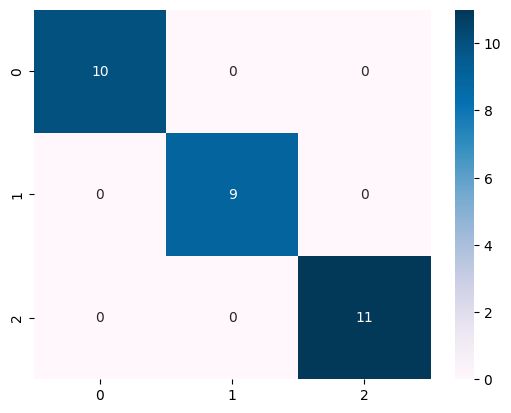

In [42]:
cf_matrix = confusion_matrix(y_test, predicted)
sns.heatmap(cf_matrix, cmap="PuBu", annot=True, fmt='.0f')
plt.show()

SVM

In [43]:
param_grid_svm = {'C': [0.1, 1, 10, 100], #1000
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'poly']}

SVM_grid = GridSearchCV(svm.SVC(), param_grid_svm, cv=5)
SVM_grid.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'poly']})

In [44]:
print(SVM_grid.best_params_)

print(SVM_grid.best_estimator_)

{'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
SVC(C=0.1, gamma=0.1, kernel='poly')


In [45]:
svm_clf = svm.SVC(C=100, gamma=0.01, kernel='rbf')
svm_clf.fit(x_train,y_train)
predicted = svm_clf.predict(x_test)
score = svm_clf.score(x_test, y_test)
svm_score_ = np.mean(score)

print('Accuracy : %.3f' % (svm_score_))

Accuracy : 1.000


In [46]:
p=precision_score(y_test, predicted, average='weighted')
print('precision : %.3f' % (p))

r=recall_score(y_test, predicted, average='weighted')
print('recall : %.3f' % (r))

f1=f1_score(y_test, predicted, average='weighted')
print('f1-score: %.3f' % (f1))

f1_w=f1_score(y_test, predicted, average='weighted')
print('weighted f1-score: %.3f' % (f1_w))

precision : 1.000
recall : 1.000
f1-score: 1.000
weighted f1-score: 1.000


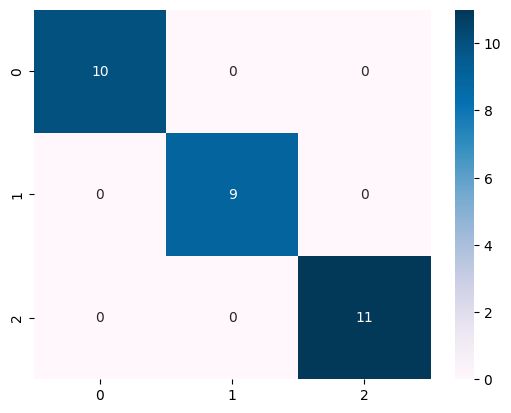

In [47]:
cf_matrix = confusion_matrix(y_test, predicted)
sns.heatmap(cf_matrix, cmap="PuBu", annot=True, fmt='.0f')
plt.show()

Random Forest

In [48]:
param_grid_rf = {
    'n_estimators': [200, 500],
    'max_depth' : [4,5,6,7,8]}

RF_grid = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid_rf, cv= 5)
RF_grid.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [4, 5, 6, 7, 8],
                         'n_estimators': [200, 500]})

In [49]:
print(RF_grid.best_params_)

{'max_depth': 4, 'n_estimators': 200}


In [50]:
r_forest = RandomForestClassifier(500,max_depth=8, random_state=5)
r_forest.fit(x_train,y_train)
predicted = r_forest.predict(x_test)
score = r_forest.score(x_test, y_test)
rf_score_ = np.mean(score)

print('Accuracy : %.3f' % (rf_score_))

Accuracy : 1.000


In [51]:
p=precision_score(y_test, predicted, average='weighted')
print('precision : %.3f' % (p))

r=recall_score(y_test, predicted, average='weighted')
print('recall : %.3f' % (r))

f1=f1_score(y_test, predicted, average='weighted')
print('f1-score: %.3f' % (f1))

f1_w=f1_score(y_test, predicted, average='weighted')
print('weighted f1-score: %.3f' % (f1_w))

precision : 1.000
recall : 1.000
f1-score: 1.000
weighted f1-score: 1.000


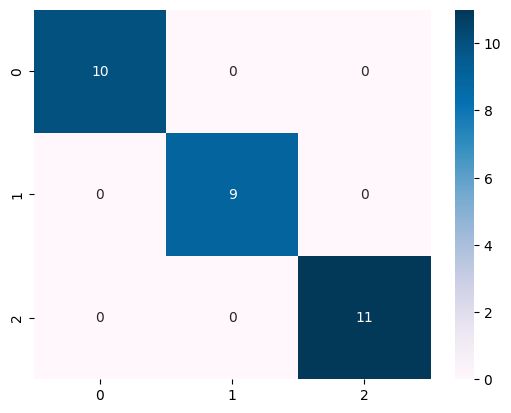

In [52]:
cf_matrix = confusion_matrix(y_test, predicted)
sns.heatmap(cf_matrix, cmap="PuBu", annot=True, fmt='.0f')
plt.show()

Naive Bayes

In [53]:
nb_model = GaussianNB()
nb_model.fit(x_train,y_train)
predicted = nb_model.predict(x_test)
score = nb_model.score(x_test, y_test)

print('Accuracy : %.3f' % (score))

Accuracy : 1.000


In [54]:
p=precision_score(y_test, predicted, average='weighted')
print('precision : %.3f' % (p))

r=recall_score(y_test, predicted, average='weighted')
print('recall : %.3f' % (r))

f1=f1_score(y_test, predicted, average='weighted')
print('f1-score: %.3f' % (f1))

f1_w=f1_score(y_test, predicted, average='weighted')
print('weighted f1-score: %.3f' % (f1_w))

precision : 1.000
recall : 1.000
f1-score: 1.000
weighted f1-score: 1.000


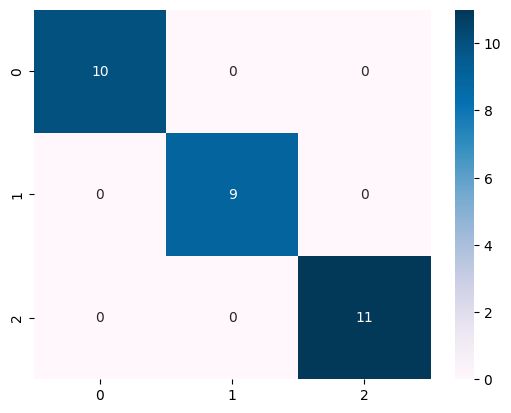

In [55]:
cf_matrix = confusion_matrix(y_test, predicted)
sns.heatmap(cf_matrix, cmap="PuBu", annot=True, fmt='.0f')
plt.show()

In [58]:
ets=time.time()
et=ets-st
print(f"Execution time:{et}s")

Execution time:7.956397294998169s
